In [303]:
# NB FOR RILEY; Make sure to install dependencies in /mnt and not /home
import os
import numpy as np  
import sys
from stl import mesh, main
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import pyvista as pv

# Functions
def find_mins_maxs(obj): # Find bottom left and top right coordinates of the bounding box
    minx = obj.x.min()
    maxx = obj.x.max()
    miny = obj.y.min()
    maxy = obj.y.max()
    minz = obj.z.min()
    maxz = obj.z.max()
    return minx, maxx, miny, maxy, minz, maxz

# Construct Uniform Grid
def construct_uniform_grid(mesh,sf):
    # mesh is a mesh object from stl 
    minx, maxx, miny, maxy, minz, maxz = find_mins_maxs(mesh)
    SF = sf # 1/SF resolution
    xdim = int((maxx-minx)/SF)
    ydim = int((maxy-miny)/SF)
    zdim = int((maxz-minz)/SF)
    xyz_space = 1*SF
    grid = pv.UniformGrid(
        dims=(xdim, ydim, zdim),
        spacing=(xyz_space,xyz_space,xyz_space),
        origin=(minx, miny, minz),
        )
    return grid # returns a grid object from pyvista

def get_triangles_and_points(mesh,grid):
    triangles = mesh.vectors
    points = grid.points
    return triangles, points

def write_points_to_file(file,points):
    a_file = open(file, "w")
    for row in points:
        np.savetxt(a_file, [row])
    a_file.close()

# Points Validation
# Current possible method for removing points within boundaries:
# Create infinite ray from point i into any direction and calculate the amount of times the ray intersects triangles within the polyhedron
# If the amount of intersections is odd, then the point is within the boundary
# If the # of intersections is even, then the point is outside of the boundary
# Pseudocode from https://stackoverflow.com/questions/44513525/testing-whether-a-3d-point-is-inside-a-3d-polyhedron: 

"""
Inside(Polyhedron P, point q)
   Segment S = [q, q+(0,0,1e30)]
   count = 0
   For each triangle T of P
      If Intersect(S,T)
            count = count + 1
      End if
   End for
   return odd(count)
End

Intersect([q1,q2],(t1,t2,t3))
  s1 = orient3d(q1,t1,t2,t3)
  s2 = orient3d(q2,t1,t2,t3)
  // Test whether the two extermities of the segment
  // are on the same side of the supporting plane of
  // the triangle
  If(s1 == s2) 
     return false
  End if
  // Now we know that the segment 'straddles' the supporing
  // plane. We need to test whether the three tetrahedra formed
  // by the segment and the three edges of the triangle have
  // the same orientation
  s3 = orient3d(q1,q2,t1,t2)
  s4 = orient3d(q1,q2,t2,t3)
  s5 = orient3d(q1,q2,t3,t1)
  return (s3 == s4 AND s4 == s5)
End

Orient3d(a,b,c,d)
    // Computes the sign of the signed volume  
    // of the tetrahedron (a,b,c,d)
    return Sign( dot(cross(b-a,c-a),d-a) )
End
"""
def find_valid_points(triangles,points):
    valid_points = np.zeros(len(points))
    i=0
    for p in points:
        valid_points[i] = not inside(triangles,p)
        i=i+1
    P = points[np.invert(valid_points.astype(bool))]
    return P

def inside(triangles,p):
    # Find the rays in the positive x and y, and negative x and y directions of a point
    # and counts intersections of each ray, if number of intersections = 0 or odd then it is outside

    # Change the bounding box function to this below:
    minx = np.amin(np.amin(triangles, axis = 0), axis = 0)[0]
    maxx = np.amax(np.amax(triangles, axis = 0), axis = 0)[0]
    miny = np.amin(np.amin(triangles, axis = 0), axis = 0)[1]
    maxy = np.amax(np.amax(triangles, axis = 0), axis = 0)[1]
    minz = np.amin(np.amin(triangles, axis = 0), axis = 0)[2]
    maxz = np.amax(np.amax(triangles, axis = 0), axis = 0)[2]
    ray_vec_pos_x = np.array([maxx-minx, 0, 0])
    ray_vec_neg_x = np.array([-(maxx-minx), 0, 0])
    #ray_vec_pos_y = np.array([0, maxy-miny, 0])
    #ray_vec_neg_y = np.array([0, -(maxy-miny), 0])
    ray_vec_neg_z = np.array([0, 0, -(maxz-minz)])
    count_pos_x = 0
    count_neg_x = 0
    #count_pos_y = 0
    #count_neg_y = 0
    count_neg_z = 0
    for triangle in triangles:
        if ray_triangle_intersection(p,ray_vec_pos_x,triangle):
            count_pos_x = count_pos_x+1
        if ray_triangle_intersection(p,ray_vec_neg_x,triangle):
            count_neg_x = count_neg_x+1
        #if ray_triangle_intersection(p,ray_vec_pos_y,triangle):
            #count_pos_y = count_pos_y+1
        #if ray_triangle_intersection(p,ray_vec_neg_y,triangle):
            #count_neg_y = count_neg_y+1
        if ray_triangle_intersection(p,ray_vec_neg_z,triangle):
            count_neg_z = count_neg_z+1
    if count_neg_z == 0:
        return False
    elif count_pos_x == 0 or count_neg_x == 0: #or count_pos_y == 0 or count_neg_y == 0:
        return False
    elif count_pos_x % 2 == 1 or count_neg_x % 2 == 1: #or count_pos_y % 2 == 1 or count_neg_y % 2 == 1:
        return False
    else:
        return True


# The following method is adapted from pyvista's documentation on the Moeller-Trumbore Method
def ray_triangle_intersection(ray_start, ray_vec, triangle):
    """Moeller–Trumbore intersection algorithm.

        Parameters
        ----------
        ray_start : np.ndarray
            Length three numpy array representing start of point.

        ray_vec : np.ndarray
            Direction of the ray.

        triangle : np.ndarray
            ``3 x 3`` numpy array containing the three vertices of a
            triangle.

        Returns
        -------
        bool
            ``True`` when there is an intersection.

        tuple
            Length three tuple containing the distance ``t``, and the
            intersection in unit triangle ``u``, ``v`` coordinates.  When
            there is no intersection, these values will be:
            ``[np.nan, np.nan, np.nan]``

    """
    v1, v2, v3 = triangle
    eps = 0.000001

    # compute edges
    edge1 = v2 - v1
    edge2 = v3 - v1
    pvec = np.cross(ray_vec, edge2)
    det = edge1.dot(pvec)
    # To understand this view pyvista implementation of the algorithm
    if abs(det) < eps:  # no intersection
        return False

    inv_det = 1.0 / det
    tvec = ray_start - v1
    u = tvec.dot(pvec) * inv_det

    if u < 0.0 or u > 1.0:  # if not intersection
        return False

    qvec = np.cross(tvec, edge1)
    v = ray_vec.dot(qvec) * inv_det

    if v < 0.0 or u + v > 1.0:  # if not intersection
        return False

    t = edge2.dot(qvec) * inv_det
    if t < eps:
        return False

    return True

# Get available neighbors
def get_available_neighbors(current_node,valid_points,grid_points):
    x = np.unique(grid_points[:,0])
    y = np.unique(grid_points[:,1])
    z = np.unique(grid_points[:,2])
    index_x = int(np.where(x == current_node[0])[0])
    index_y = int(np.where(y == current_node[1])[0])
    index_z = int(np.where(z == current_node[2])[0])
    # Get possible neighbors 
    possible_neighbors = []
    # holding xy
    if index_z+1 <= len(z) - 1:
        possible_neighbors.append([x[index_x],y[index_y],z[index_z+1]])
    if index_z-1 >= 0:
        possible_neighbors.append([x[index_x],y[index_y],z[index_z-1]])
    # holding xz
    if index_y+1 <= len(y) - 1:
        possible_neighbors.append([x[index_x],y[index_y+1],z[index_z]])
    if index_y-1 >= 0:
        possible_neighbors.append([x[index_x],y[index_y-1],z[index_z]])
    # holding yz
    if index_x+1 <= len(x) - 1:
        possible_neighbors.append([x[index_x+1],y[index_y],z[index_z]])
    if index_x-1 >= 0:
        possible_neighbors.append([x[index_x-1],y[index_y],z[index_z]])

    # Check if each possible node exists in the valid points list:
    # Have to coerce P from array to list
    p_list=valid_points.tolist()
    valid_neighbors = []
    # If possible neighbor is in Plist, then add it to valid_neighbors
    for i in range(len(possible_neighbors)):
        if possible_neighbors[i] in p_list:
            valid_neighbors.append(possible_neighbors[i])
    return valid_neighbors


def all_node_neighbors(outside_points,grid_points):
    # Gets the available neighbor nodes of each valid points and stores it into a dictionary
    for i in range(len(outside_points)):
        current_node = outside_points[i]
        avail_nodes = get_available_neighbors(current_node,outside_points,grid_points)
        node = {"node": current_node.tolist(), "neighbors": avail_nodes}
        node_dictionary[i] = node
    return node_dictionary

C:\Users\Riley Ylagan\AppData\Local\Temp\ipykernel_13184\1015509948.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


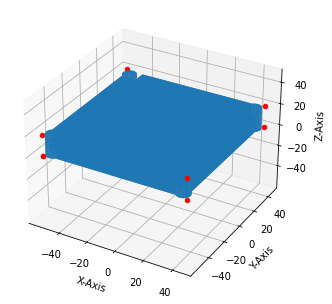

(711, 3)
-55.0
44.999996
-55.0
44.999996
-4.6629367e-15
20.0


In [285]:
# Create a new plot
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
# Import maze mesh
your_mesh = mesh.Mesh.from_file('../data/first_iteration.STL')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))
minx, maxx, miny, maxy, minz, maxz = find_mins_maxs(your_mesh)
# Auto scale to the mesh size
scale = your_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
axes.scatter(minx,miny,minz,color='red')
axes.scatter(maxx,maxy,maxz,color='red')
axes.scatter(minx,maxy,minz,color='red')
axes.scatter(maxx,miny,maxz,color='red')
axes.scatter(minx,miny,maxz,color='red')
axes.scatter(minx,maxy,maxz,color='red')

axes.scatter(maxx,miny,minz,color='red')
axes.scatter(minx,miny,minz,color='red')
axes.scatter(minx,maxy,minz,color='red')
axes.scatter(maxx,maxy,minz,color='red')
axes.set_xlabel('X-Axis', rotation=45)
axes.set_ylabel('Y-Axis', rotation=45)
axes.set_zlabel('Z-Axis', rotation=45)
# Show the plot to the screen
pyplot.show()

#points = np.around(np.unique(your_mesh.vectors.reshape([int(your_mesh.vectors.size/3), 3]), axis=0),2)
#points.size
#print("Points are", points.tolist())
points = your_mesh.points.reshape([-1, 3])
# extract vertices of the triangle faces
point_list = np.unique(points, axis=0)
print(point_list.shape)
a_file = open("test.txt", "w")
for row in point_list:
    np.savetxt(a_file, [row])

a_file.close()


print(minx)
print(maxx)
print(miny)
print(maxy)
print(minz)
print(maxz)
# Bottom left and top right of bounding box

20
20
4


C:\Users\Riley Ylagan\AppData\Local\Programs\Python\Python39\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


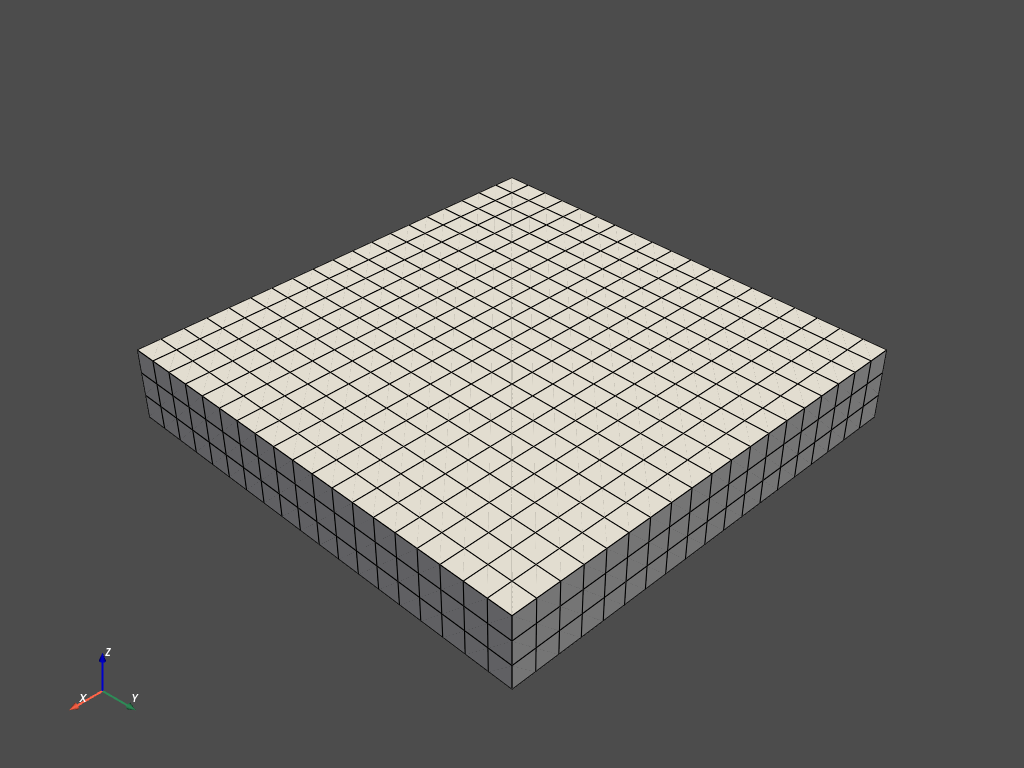

[[-5.5000000e+01 -5.5000000e+01 -4.6629367e-15]
 [-5.0000000e+01 -5.5000000e+01 -4.6629367e-15]
 [-4.5000000e+01 -5.5000000e+01 -4.6629367e-15]
 ...
 [ 3.0000000e+01  4.0000000e+01  1.5000000e+01]
 [ 3.5000000e+01  4.0000000e+01  1.5000000e+01]
 [ 4.0000000e+01  4.0000000e+01  1.5000000e+01]]
[[-5.5000000e+01 -5.5000000e+01 -4.6629367e-15]
 [-5.0000000e+01 -5.5000000e+01 -4.6629367e-15]
 [-4.5000000e+01 -5.5000000e+01 -4.6629367e-15]
 ...
 [ 3.0000000e+01  4.0000000e+01  1.5000000e+01]
 [ 3.5000000e+01  4.0000000e+01  1.5000000e+01]
 [ 4.0000000e+01  4.0000000e+01  1.5000000e+01]]


In [155]:
xy = (maxx-minx)/(maxy-miny) # ratio between x and y distance
xz = (maxx-minx)/(maxz-minz) # ratio between x and z distance
yz = (maxy-miny)/(maxy-miny) # ratio between y and z distance
SF = 5 # 1/SF resolution
xdim = int((maxx-minx)/SF)
ydim = int((maxy-miny)/SF)
zdim = int((maxz-minz)/SF)
xyz_space = 1*SF

print(xdim)
print(ydim)
print(zdim)
grid = pv.UniformGrid(
    dims=(xdim, ydim, zdim),
    spacing=(xyz_space,xyz_space,xyz_space),
    origin=(minx, miny, minz),
)
type(grid.points)
grid.plot(show_edges=True)

x = grid.points[:,0]
y = grid.points[:,1]
z = grid.points[:,2]
print(grid.points)
#a_file = open("test.txt", "w")
#for row in grid.points:
#    np.savetxt(a_file, [row])

#a_file.close()

print(grid.points)


C:\Users\Riley Ylagan\AppData\Local\Temp\ipykernel_13184\3185625906.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


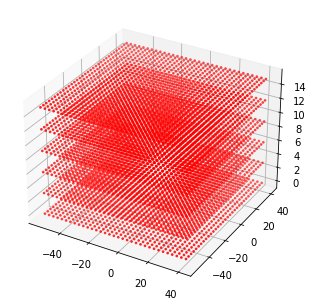

In [50]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
your_mesh = mesh.Mesh.from_file('../data/first_iteration.STL')
#axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

# Auto scale to the mesh size
scale = your_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
axes.scatter(x,y,z,s=SF,color='red')
pyplot.show()

Note: Running with Scaling of 1, the discretization of the valid points grid took 507 minutes!!!

Also more ideas that I need to jot down.
For start and end points, we can probably just find the nearest grid point to the points and start/end there


In [160]:
# Find available neighbors
# Possible points
x = [1,2,3]
y = [1,2,3]
z = [1,2,3]

current_node = [2,2,2]
index_x = x.index(current_node[0])
index_y = y.index(current_node[1])
index_z = z.index(current_node[2])

# Get neighbors 
# holding xy
node1 = [x[index_x],y[index_y],z[index_z+1]] 
node2 = [x[index_x],y[index_y],z[index_z-1]]

node3 = [x[index_x],y[index_y+1],z[index_z]] 
node4 = [x[index_x],y[index_y-1],z[index_z]]

node5 = [x[index_x+1],y[index_y],z[index_z]] 
node6 = [x[index_x-1],y[index_y],z[index_z]]
# Check if each neighbor node is in the valid points array
print("Current node: ", current_node)
print(node1,node2)
print(node3,node4)
print(node5,node6)


Current node:  [2, 2, 2]
[2, 2, 3] [2, 2, 1]
[2, 3, 2] [2, 1, 2]
[3, 2, 2] [1, 2, 2]


(404, 3)


In [253]:
current_node = P[0]
avail_nodes = get_available_neighbors(current_node,P,grid.points)
print("current node: ",current_node)
print(avail_nodes)
print(type(current_node))

current node:  [-10. -50.  10.]
[[-10.0, -50.0, 14.999999999999995], [-10.0, -45.0, 9.999999999999995]]
<class 'numpy.ndarray'>


In [276]:
import json 
node_dictionary = {}
for i in range(len(P)):
    current_node = P[i]
    avail_nodes = get_available_neighbors(current_node,P,grid.points)
    node = {"node": current_node.tolist(), "neighbors": avail_nodes}
    node_dictionary[i] = node



print(json.dumps(node_dictionary,indent=2))
text_file = open("sample.txt", "w")
n = text_file.write(json.dumps(node_dictionary,indent=2))
text_file.close()

{
  "0": {
    "node": [
      -10.0,
      -50.0,
      9.999999999999995
    ],
    "neighbors": [
      [
        -10.0,
        -50.0,
        14.999999999999995
      ],
      [
        -10.0,
        -45.0,
        9.999999999999995
      ]
    ]
  },
  "1": {
    "node": [
      -45.0,
      -45.0,
      9.999999999999995
    ],
    "neighbors": [
      [
        -45.0,
        -45.0,
        14.999999999999995
      ],
      [
        -45.0,
        -40.0,
        9.999999999999995
      ],
      [
        -40.0,
        -45.0,
        9.999999999999995
      ]
    ]
  },
  "2": {
    "node": [
      -40.0,
      -45.0,
      9.999999999999995
    ],
    "neighbors": [
      [
        -40.0,
        -45.0,
        14.999999999999995
      ],
      [
        -40.0,
        -40.0,
        9.999999999999995
      ],
      [
        -35.0,
        -45.0,
        9.999999999999995
      ],
      [
        -45.0,
        -45.0,
        9.999999999999995
      ]
    ]
  },
  "3": {
  

In [304]:
#main?
#import mesh and construct uniform grid
my_mesh = mesh.Mesh.from_file('../data/first_iteration.STL')
SF = 4
grid = construct_uniform_grid(my_mesh,SF)
# extract triangles and points
triangles,grid_points = get_triangles_and_points(my_mesh,grid)
outside_points = find_valid_points(triangles,grid_points)
node_dictionary = {}



In [308]:
write_points_to_file("points_sf4.xyz",outside_points)


In [317]:
test_node = outside_points[57].tolist()
test_points = outside_points.tolist()


index = test_points.index(test_node)

57